In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('../book_train.parquet')])


In [4]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [5]:
def add_wap1(book):
    book['wap1'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
              book['ask_size1'] + book['bid_size1'])

def add_wap2(book):
    book['wap2'] = (book['bid_price2'] * book['ask_size2'] + book['ask_price2'] * book['bid_size2']) / (
              book['ask_size2'] + book['bid_size2'])

def add_log_return1(book):
    book['log_price1'] = np.log(book['wap1'])
    book['log_return1'] = book.groupby(['time_id'])['log_price1'].diff()
    
def add_log_return2(book):
    book['log_price2'] = np.log(book['wap2'])
    book['log_return2'] = book.groupby(['time_id'])['log_price2'].diff()
    
def get_vol1(book):
    return book.groupby(['time_id'])[['log_return1']].apply(lambda x: np.sum(x**2)**0.5).rename(
    {'log_return1': 'vol1'})
def get_vol2(book):
    return book.groupby(['time_id'])[['log_return2']].apply(lambda x: np.sum(x**2)**0.5).rename(
    {'log_return2': 'vol2'})

In [52]:
train = pd.read_csv('../train.csv')

In [53]:
stock_id = stock_ids[0]
book = pd.read_parquet('../book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('../trade_train.parquet/stock_id=' + str(stock_id))

In [54]:
book = book.merge(trades, on=['time_id', 'seconds_in_bucket'], how='left')
book['stock_id'] = stock_id

In [55]:
add_wap1(book)
add_wap2(book)

add_log_return1(book)
add_log_return2(book)

In [62]:
book['spread'] = book['ask_price1'] - book['bid_price1']

In [74]:
prices_col = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']
sizes_col = ['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

In [84]:
book[[x + '_diff' for x in prices_col]] = book.groupby(['time_id', 'stock_id'])[prices_col].diff().fillna(0)
book[[x + '_diff' for x in sizes_col]] = book.groupby(['time_id', 'stock_id'])[sizes_col].diff().fillna(0)

In [235]:
def get_features1(book):
    features1 = book.groupby(['time_id', 'stock_id'])[[x + '_diff' for x in prices_col]].agg(
        ['mean', 'std'])
    
    return features1

In [236]:
def get_features2(book):

    features2 = book.groupby(['time_id', 'stock_id'])[[x + '_diff' for x in sizes_col]].agg(
        ['mean', 'std'])
    
    return features2

In [237]:
def get_features3(book):
    features3 = book.dropna().groupby(['time_id', 'stock_id']).agg({'size': [np.sum, np.mean, np.std], 
                                                               'order_count': [np.sum, np.mean, np.std], 
                                                               'log_return1': lambda x: np.mean(np.abs(x)),
                                                               'log_return2': lambda x: np.mean(np.abs(x))})
    
    return features3

In [238]:
def get_features4(book):
    features4 = book.groupby(['time_id', 'stock_id'])[['log_return1', 'log_return2']].agg(
        lambda x: np.sqrt(np.sum(np.square(x)))).astype(float)
    
    return features4

In [239]:
def get_features5(book):
    features5 = book.groupby(['time_id', 'stock_id'])['spread'].agg(
        ['mean', 'std'])
    
    return features5

In [412]:
def get_features6(book):
    features6 = book.groupby(['time_id', 'stock_id'])[sizes_col + ['spread']].last()
    return features6

In [471]:
def get_features7(df, cols):
    pass

In [488]:
data_df[['time_id','log_return1', 'log_return2']].groupby('time_id').agg(['mean', 'std', 'max', 'min'])

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [490]:
feature_functions = [get_features1, get_features2, get_features3, get_features4, get_features5]

def get_features(book):
    
    add_wap1(book)
    add_wap2(book)

    add_log_return1(book)
    add_log_return2(book)
    
    book['spread'] = book['ask_price1'] - book['bid_price1']
    
    prices_col = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']
    sizes_col = ['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']
    book[[x + '_diff' for x in prices_col]] = book.groupby(['time_id', 'stock_id'])[prices_col].diff().fillna(0)
    book[[x + '_diff' for x in sizes_col]] = book.groupby(['time_id', 'stock_id'])[sizes_col].diff().fillna(0)
    
    
    features = []
    for snb in [0]:
        features += [func(book[book.seconds_in_bucket >= snb]) for func in feature_functions]
    
    
    features += [get_features6(book)]
    
    data_df = pd.concat(features, axis=1)
    data_df.columns = [x[0] + '_' + x[1] if isinstance(x, tuple) else x for x in data_df.columns]
    data_df = data_df.reset_index()
    
    return data_df

In [491]:
data_dfs = []

for stock_id in tqdm(stock_ids[:5]):
    book = pd.read_parquet('../book_train.parquet/stock_id=' + str(stock_id))
    trades = pd.read_parquet('../trade_train.parquet/stock_id=' + str(stock_id))
    
    book = book.merge(trades, on=['time_id', 'seconds_in_bucket'], how='left')
    book['stock_id'] = stock_id
    
    data_dfs.append(get_features(book))


100%|██████████| 5/5 [00:51<00:00, 10.28s/it]


In [416]:
data_df = pd.concat(data_dfs)

In [417]:
data_df = pd.merge(data_df, train, on=['time_id', 'stock_id'], how='left')

In [418]:
time_ids = data_df.time_id.unique()

In [446]:
seed = 519
np.random.seed(seed)

train_ratio = 0.9
train_size = int(train_ratio * len(time_ids))

train_inds = np.random.choice(range(len(time_ids)), size=train_size, replace=False)
test_inds = np.delete(range(len(time_ids)), train_inds)

train_time_ids = time_ids[train_inds]
test_time_ids = time_ids[test_inds]

In [447]:
X_train = data_df[data_df['time_id'].isin(train_time_ids)].drop(columns=['time_id', 'target'])
X_test = data_df[data_df['time_id'].isin(test_time_ids)].drop(columns=['time_id', 'target'])

y_train = data_df[data_df['time_id'].isin(train_time_ids)]['target']
y_test = data_df[data_df['time_id'].isin(test_time_ids)]['target']

In [448]:
from sklearn.metrics import make_scorer

my_scorer = make_scorer(rmspe, greater_is_better=False)
def lgb_scorer(y_true, y_pred, weights):
    return 'rmspe', rmspe(y_true, y_pred), False

In [449]:
import lightgbm as lgb

In [450]:
reg = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=300)

<AxesSubplot:xlabel='stock_id'>

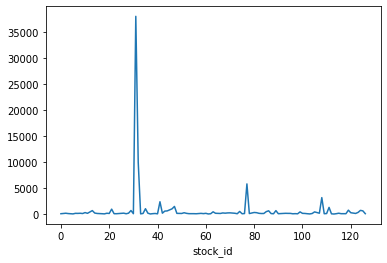

In [461]:
X_train.groupby(['stock_id'])['ask_size1'].mean().plot()

In [452]:
reg.fit(X_train, y_train, sample_weight=1 / np.square(y_train), 
       eval_set=(X_test, y_test), 
                        eval_metric=lgb_scorer)

[1]	valid_0's l2: 9.83015e-06	valid_0's rmspe: 0.497003
[2]	valid_0's l2: 8.58756e-06	valid_0's rmspe: 0.460005
[3]	valid_0's l2: 7.55197e-06	valid_0's rmspe: 0.427681
[4]	valid_0's l2: 6.68833e-06	valid_0's rmspe: 0.399453
[5]	valid_0's l2: 5.97715e-06	valid_0's rmspe: 0.375402
[6]	valid_0's l2: 5.3826e-06	valid_0's rmspe: 0.354654
[7]	valid_0's l2: 4.87287e-06	valid_0's rmspe: 0.336749
[8]	valid_0's l2: 4.45006e-06	valid_0's rmspe: 0.321511
[9]	valid_0's l2: 4.0898e-06	valid_0's rmspe: 0.308449
[10]	valid_0's l2: 3.7884e-06	valid_0's rmspe: 0.297683
[11]	valid_0's l2: 3.53521e-06	valid_0's rmspe: 0.288424
[12]	valid_0's l2: 3.32268e-06	valid_0's rmspe: 0.280684
[13]	valid_0's l2: 3.13753e-06	valid_0's rmspe: 0.274254
[14]	valid_0's l2: 2.97949e-06	valid_0's rmspe: 0.268814
[15]	valid_0's l2: 2.8484e-06	valid_0's rmspe: 0.26438
[16]	valid_0's l2: 2.73184e-06	valid_0's rmspe: 0.260618
[17]	valid_0's l2: 2.63308e-06	valid_0's rmspe: 0.257575
[18]	valid_0's l2: 2.54729e-06	valid_0's rmsp

[147]	valid_0's l2: 1.78507e-06	valid_0's rmspe: 0.238537
[148]	valid_0's l2: 1.7839e-06	valid_0's rmspe: 0.238506
[149]	valid_0's l2: 1.78319e-06	valid_0's rmspe: 0.238494
[150]	valid_0's l2: 1.7834e-06	valid_0's rmspe: 0.238476
[151]	valid_0's l2: 1.7824e-06	valid_0's rmspe: 0.238468
[152]	valid_0's l2: 1.78132e-06	valid_0's rmspe: 0.238412
[153]	valid_0's l2: 1.78104e-06	valid_0's rmspe: 0.238384
[154]	valid_0's l2: 1.78101e-06	valid_0's rmspe: 0.238512
[155]	valid_0's l2: 1.78025e-06	valid_0's rmspe: 0.238491
[156]	valid_0's l2: 1.77944e-06	valid_0's rmspe: 0.238481
[157]	valid_0's l2: 1.77874e-06	valid_0's rmspe: 0.23846
[158]	valid_0's l2: 1.77792e-06	valid_0's rmspe: 0.238461
[159]	valid_0's l2: 1.77763e-06	valid_0's rmspe: 0.238426
[160]	valid_0's l2: 1.77734e-06	valid_0's rmspe: 0.238419
[161]	valid_0's l2: 1.77645e-06	valid_0's rmspe: 0.238592
[162]	valid_0's l2: 1.77603e-06	valid_0's rmspe: 0.238588
[163]	valid_0's l2: 1.7756e-06	valid_0's rmspe: 0.238557
[164]	valid_0's l2:

[290]	valid_0's l2: 1.73255e-06	valid_0's rmspe: 0.239564
[291]	valid_0's l2: 1.73226e-06	valid_0's rmspe: 0.239551
[292]	valid_0's l2: 1.73223e-06	valid_0's rmspe: 0.239526
[293]	valid_0's l2: 1.7315e-06	valid_0's rmspe: 0.239499
[294]	valid_0's l2: 1.73223e-06	valid_0's rmspe: 0.239498
[295]	valid_0's l2: 1.73218e-06	valid_0's rmspe: 0.23951
[296]	valid_0's l2: 1.7321e-06	valid_0's rmspe: 0.239493
[297]	valid_0's l2: 1.73193e-06	valid_0's rmspe: 0.239481
[298]	valid_0's l2: 1.73183e-06	valid_0's rmspe: 0.23949
[299]	valid_0's l2: 1.73109e-06	valid_0's rmspe: 0.239494
[300]	valid_0's l2: 1.73087e-06	valid_0's rmspe: 0.2395


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [453]:
rmspe(y_test, reg.predict(X_test))

0.2394998120724511

In [454]:
rmspe(y_train, reg.predict(X_train))

0.2181799505668542

In [431]:
X_train.shape

(386037, 118)

In [430]:
reg.feature_importances_

array([464,  26,  64,  35,  75,  34,  47,  45,  42,  62,  39,  60,  52,
        76,  52,  61,  44,  74, 104, 119, 150,  66, 165, 112,  59, 277,
       159, 307, 276,  29,  42,  23,  60,  37,  37,  27,  58,  49,  55,
        52,  35,  44,  35,  44,  42,  38,  29,  36, 172,  38,  51, 112,
        68, 194,  95, 103,  72,  27,  84,  34,  79,  25,  55,  26,  49,
        48,  41,  41,  39,  46,  42,  35,  55,  48,  37,  48, 200,  42,
        57, 104,  73, 204, 115, 144,  60,  49,  62,  36,  52,  26,  59,
        38,  55,  53,  36,  47,  41,  48,  53,  48,  51,  51,  42,  37,
       218,  54,  48,  97,  73, 195, 138, 185,  99,  49,  47,  65,  48,
       119], dtype=int32)